# Item-Item Recommender System on MovieLens 32M

A step-by-step notebook that builds and evaluates item-item recommenders using implicit feedback, temporal splitting, and hyperparameter optimization.

**What you will build:**
- Baselines: `Top Popular`, `Random`
- Item-item models with SimilariPy: `Dot Product`, `RP3Beta`, `Asymmetric Cosine`
- Hyperparameters optimization with Optuna 
- Final test-set comparison and recommendation examples with movie metadata
- 2D item-map visualization with UMAP

**Why SimilariPy in this notebook:**
- It computes sparse item-item similarity efficiently (Cython + OpenMP), which is good in case we want to run an hyperparameters search.
- It exposes recommender-oriented controls (`k`, `shrink`, `shrink_type`, model-specific parameters) in a consistent API.



## 0) Environment & Imports

Install dependencies if needed (uncomment the first line if you're running in a fresh environment).


In [1]:
# !pip install -U pandas numpy scipy matplotlib seaborn optuna umap-learn similaripy scikit-learn

import os
import zipfile
from pathlib import Path
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import optuna
from optuna.importance import get_param_importances

import similaripy as sim
from sklearn.decomposition import TruncatedSVD
import umap

sns.set_theme(style="whitegrid")
np.random.seed(42)


## 1) Introduction

### Collaborative filtering in one paragraph
Collaborative filtering learns from interaction patterns (users x items) rather than content features. If users who liked item A also liked item B, then A and B are considered similar.

### Why item-item recommenders?
Item-item KNN methods are practical and explainable: we can recommend items that are similar to the items a user already interacted with and do not require a full recomputation in case we want serve a recommendation to a new user.

### Why convert explicit ratings to implicit feedback?
In many production scenarios, we optimize ranking from *signals of interaction* (click/watch/purchase), not absolute rating values. For this notebook we convert ratings to implicit events (`1 = interaction exists`) to focus on top-N ranking.

### How SimilariPy is used here
1. Build a sparse interaction matrix `URM` (users x items), then transpose to `items x users` for item-item similarity.
2. Train a sparse similarity matrix `W` (items x items) with SimilariPy; only top-`k` neighbors are retained per item.
3. Score candidates with sparse matrix multiplication: `scores = context_profile * W`.
4. Remove seen/context items from the ranked list at inference time.

This is the classic high-throughput item-KNN pipeline used in many production recommenders.


## 2) Dataset Setup

We use a well known dataset: MovieLens 32M (`ml-32m`). This dataset includes:
- `ratings.csv`: `userId`, `movieId`, `rating`, `timestamp`
- `movies.csv`: `movieId`, `title`, `genres`

At load time we also engineer two single-value metadata fields from titles:
- `release_year`
- `release_decade` (used later to color UMAP)

In [2]:
DATA_DIR = Path("datasets_bench")
DATA_DIR.mkdir(parents=True, exist_ok=True)

ML32M_URL = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
ML32M_ZIP = DATA_DIR / "ml-32m.zip"
ML32M_DIR = DATA_DIR / "ml-32m"


def download_and_extract_movielens_32m(url=ML32M_URL, zip_path=ML32M_ZIP, extract_dir=DATA_DIR):
    if not ML32M_DIR.exists():
        if not zip_path.exists():
            print(f"Downloading MovieLens 32M from: {url}")
            urlretrieve(url, zip_path)
            print(f"Downloaded: {zip_path}")
        else:
            print(f"Using existing zip: {zip_path}")

        print(f"Extracting to: {extract_dir}")
        with zipfile.ZipFile(zip_path, "r") as zf:
            zf.extractall(extract_dir)
        print("Extraction complete.")
    else:
        print(f"Dataset already available at: {ML32M_DIR}")


download_and_extract_movielens_32m()


Dataset already available at: datasets_bench/ml-32m


In [3]:
ratings_path = ML32M_DIR / "ratings.csv"
movies_path = ML32M_DIR / "movies.csv"

ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)

# Precompute single-value temporal metadata from title suffix "(YYYY)"
movies["release_year"] = pd.to_numeric(
    movies["title"].str.extract(r"\((\d{4})\)\s*$")[0],
    errors="coerce",
).astype("Int64")
movies["release_decade"] = ((movies["release_year"] // 10) * 10).astype("Int64")
movies["decade_label"] = np.where(
    movies["release_decade"].notna(),
    movies["release_decade"].astype(str) + "s",
    "Unknown",
)

print("ratings shape:", ratings.shape)
print("movies shape:", movies.shape)
ratings.head()


ratings shape: (32000204, 4)
movies shape: (87585, 6)


,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [4]:
# Join in simple popularity stats for a richer metadata table
movie_stats = (
    ratings.groupby("movieId")
    .agg(num_ratings=("rating", "size"), avg_rating=("rating", "mean"))
    .reset_index()
)

metadata_sample = (
    movies.merge(movie_stats, on="movieId", how="left")
    .sort_values("num_ratings", ascending=False)
    .head(15)
)
metadata_sample.head()


,movieId,title,genres,release_year,release_decade,decade_label,num_ratings,avg_rating
314,318,"Shawshank Redemption, The (1994)",Crime|Drama,1994,1990,1990s,102929.0,4.404614
351,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1994,1990,1990s,100296.0,4.052744
292,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994,1990,1990s,98409.0,4.196969
2480,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999,1990,1990s,93808.0,4.156437
585,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991,1990,1990s,90330.0,4.148367


## 3) Data Preprocessing

Steps:
1. Deduplicate (`userId`, `movieId`) keeping latest timestamp in case the user has multiple events for the same item.
2. Convert explicit ratings to implicit interactions (`value = 1`).
3. Remove cold users/items iteratively:
   - users with fewer than 5 interactions
   - items with fewer than 10 interactions
4. Trim the most extreme power users (upper tail) with a quantile-based cap.
5. Label encoding: convert `movieId` and `userId` into contiguous integer indices starting from 0 to create sparse matrices.



In [5]:
# 1) Deduplicate interactions by user-item pair (keep latest event)
interactions = ratings[["userId", "movieId", "timestamp"]].copy()
interactions = (
    interactions.sort_values(["userId", "movieId", "timestamp"])
    .drop_duplicates(["userId", "movieId"], keep="last")
)

# 2) Explicit -> implicit (binary)
interactions["value"] = 1.0

print("Interactions after deduplication:", len(interactions))
interactions.head()


Interactions after deduplication: 32000204


,userId,movieId,timestamp,value
0,1,17,944249077,1.0
1,1,25,944250228,1.0
2,1,29,943230976,1.0
3,1,30,944249077,1.0
4,1,32,943228858,1.0


In [6]:
def iterative_cold_filter(df, min_user_interactions=5, min_item_interactions=10):
    filtered = df.copy()
    while True:
        start_size = len(filtered)

        user_counts = filtered["userId"].value_counts()
        keep_users = user_counts[user_counts >= min_user_interactions].index
        filtered = filtered[filtered["userId"].isin(keep_users)]

        item_counts = filtered["movieId"].value_counts()
        keep_items = item_counts[item_counts >= min_item_interactions].index
        filtered = filtered[filtered["movieId"].isin(keep_items)]

        if len(filtered) == start_size:
            break

    return filtered


MIN_USER_INTERACTIONS = 5
MIN_ITEM_INTERACTIONS = 10
MAX_USER_INTERACTIONS_Q = 99.5  # trim top 0.5% most active users

# Base cold-start filtering
filtered_interactions = iterative_cold_filter(
    interactions,
    min_user_interactions=MIN_USER_INTERACTIONS,
    min_item_interactions=MIN_ITEM_INTERACTIONS,
)

# Optional upper-tail user filtering
user_counts_tmp = filtered_interactions["userId"].value_counts()
max_user_interactions = int(np.percentile(user_counts_tmp, MAX_USER_INTERACTIONS_Q))
keep_users = user_counts_tmp[user_counts_tmp <= max_user_interactions].index

before_users = filtered_interactions["userId"].nunique()
before_interactions = len(filtered_interactions)

filtered_interactions = filtered_interactions[filtered_interactions["userId"].isin(keep_users)].copy()

# Re-apply minimum filters to keep consistency after trimming
filtered_interactions = iterative_cold_filter(
    filtered_interactions,
    min_user_interactions=MIN_USER_INTERACTIONS,
    min_item_interactions=MIN_ITEM_INTERACTIONS,
)

after_users = filtered_interactions["userId"].nunique()
after_interactions = len(filtered_interactions)

print(f"Power-user cap quantile: q={MAX_USER_INTERACTIONS_Q}% -> max_user_interactions={max_user_interactions:,}")
print(f"Users: {before_users:,} -> {after_users:,}")
print(f"Interactions: {before_interactions:,} -> {after_interactions:,}")
print("Unique items:", filtered_interactions['movieId'].nunique())



Power-user cap quantile: q=99.5% -> max_user_interactions=1,645
Users: 200,948 -> 199,944
Interactions: 31,842,705 -> 29,317,041
Unique items: 24790


In [7]:
# Build contiguous IDs for sparse modeling
unique_users = filtered_interactions["userId"].drop_duplicates().to_numpy()
unique_items = filtered_interactions["movieId"].drop_duplicates().to_numpy()

user_to_idx = {u: i for i, u in enumerate(unique_users)}
item_to_idx = {m: i for i, m in enumerate(unique_items)}
idx_to_user = {i: u for u, i in user_to_idx.items()}
idx_to_item = {i: m for m, i in item_to_idx.items()}

filtered_interactions["user_idx"] = filtered_interactions["userId"].map(user_to_idx).astype(np.int32)
filtered_interactions["item_idx"] = filtered_interactions["movieId"].map(item_to_idx).astype(np.int32)

n_users = len(unique_users)
n_items = len(unique_items)

print(f"n_users={n_users:,}, n_items={n_items:,}, interactions={len(filtered_interactions):,}")


n_users=199,944, n_items=24,790, interactions=29,317,041


In [8]:
# Basic stats and time distribution
user_interactions = filtered_interactions.groupby("user_idx").size()
item_interactions = filtered_interactions.groupby("item_idx").size()

ts_dt = pd.to_datetime(filtered_interactions["timestamp"], unit="s")

stats_df = pd.DataFrame({
    "metric": [
        "n_users", "n_items", "n_interactions", "density",
        "avg_interactions_per_user", "median_interactions_per_user",
        "avg_interactions_per_item", "median_interactions_per_item",
    ],
    "value": [
        n_users,
        n_items,
        len(filtered_interactions),
        len(filtered_interactions) / (n_users * n_items),
        user_interactions.mean(),
        user_interactions.median(),
        item_interactions.mean(),
        item_interactions.median(),
    ]
})
stats_df


,metric,value
0,n_users,1.999440e+05
1,n_items,2.479000e+04
2,n_interactions,2.931704e+07
3,density,5.914734e-03
4,avg_interactions_per_user,1.466263e+02
5,median_interactions_per_user,7.200000e+01
6,avg_interactions_per_item,1.182616e+03
7,median_interactions_per_item,6.400000e+01


Users: max=1,641 | p99=1,078
Items: max=101,972 | p99=21,270


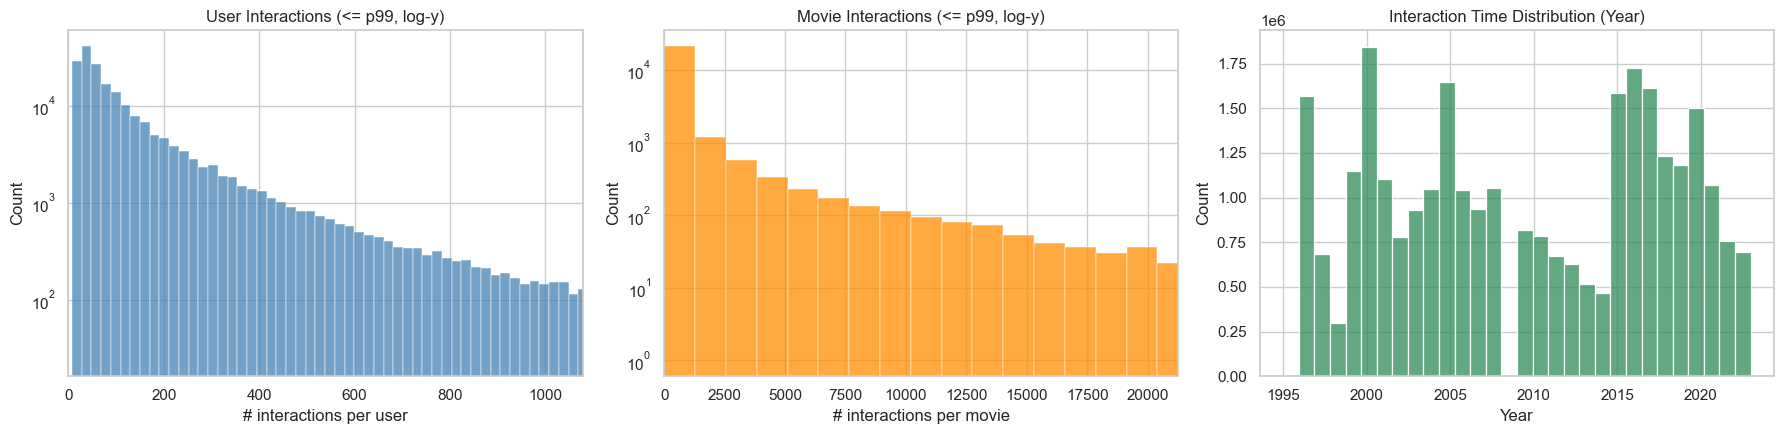

In [9]:
# Distribution diagnostics (without CCDF panels)
user_counts = user_interactions.astype(int)
item_counts = item_interactions.astype(int)

u_p99 = int(np.percentile(user_counts, 99))
i_p99 = int(np.percentile(item_counts, 99))

print(f"Users: max={user_counts.max():,} | p99={u_p99:,}")
print(f"Items: max={item_counts.max():,} | p99={i_p99:,}")

fig, axes = plt.subplots(1, 3, figsize=(18, 4.5))

# 1) Interactions per user (zoomed to p99, log-y)
sns.histplot(user_counts, bins=80, ax=axes[0], color="steelblue")
axes[0].set_yscale("log")
axes[0].set_xlim(0, max(10, u_p99))
axes[0].axvline(u_p99, ls="--", color="black", lw=1)
axes[0].set_title("User Interactions (<= p99, log-y)")
axes[0].set_xlabel("# interactions per user")

# 2) Interactions per movie (zoomed to p99, log-y)
sns.histplot(item_counts, bins=80, ax=axes[1], color="darkorange")
axes[1].set_yscale("log")
axes[1].set_xlim(0, max(10, i_p99))
axes[1].axvline(i_p99, ls="--", color="black", lw=1)
axes[1].set_title("Movie Interactions (<= p99, log-y)")
axes[1].set_xlabel("# interactions per movie")

# 3) Time distribution
sns.histplot(ts_dt.dt.year, bins=30, ax=axes[2], color="seagreen")
axes[2].set_title("Interaction Time Distribution (Year)")
axes[2].set_xlabel("Year")

plt.tight_layout()
plt.show()



## 4) Temporal Splitting

We use a **global timestamp split** (GTS):
- `train_val` window: interactions up to a global validation cutoff
- `holdout_val` window: interactions between validation and test cutoffs
- `train_test` window: interactions up to a global test cutoff
- `holdout_test` window: interactions after the global test cutoff

Then, from each holdout window, we create **one target per user** using a configurable strategy:
- `last` (default): use the user's last holdout interaction
- `random`: sample one holdout interaction per user

At inference time for a target, we build the user context from **all interactions before that target timestamp** (including post-cutoff interactions that happened before the target), consistent with the GTS protocol.



In [10]:
# Global chronological ordering with deterministic tie-breakers
interactions_global = (
    filtered_interactions
    .sort_values(["timestamp", "user_idx", "item_idx"])
    .reset_index(drop=True)
    .copy()
)
interactions_global["event_idx"] = np.arange(len(interactions_global), dtype=np.int64)


# Global cutoff points over unique timestamps
unique_ts = np.sort(interactions_global["timestamp"].unique())

def _cutoff_at_ratio(ts_array, ratio):
    idx = min(max(int(len(ts_array) * ratio), 0), len(ts_array) - 1)
    return int(ts_array[idx])


val_cutoff_ts = _cutoff_at_ratio(unique_ts, 0.80)
test_cutoff_ts = _cutoff_at_ratio(unique_ts, 0.90)
assert val_cutoff_ts < test_cutoff_ts, "Validation cutoff must be before test cutoff"


train_val_df = interactions_global[interactions_global["timestamp"] <= val_cutoff_ts].copy()
holdout_val_pool = interactions_global[
    (interactions_global["timestamp"] > val_cutoff_ts)
    & (interactions_global["timestamp"] <= test_cutoff_ts)
].copy()

train_test_df = interactions_global[interactions_global["timestamp"] <= test_cutoff_ts].copy()
holdout_test_pool = interactions_global[interactions_global["timestamp"] > test_cutoff_ts].copy()

print("val_cutoff_ts:", pd.to_datetime(val_cutoff_ts, unit="s"))
print("test_cutoff_ts:", pd.to_datetime(test_cutoff_ts, unit="s"))
print("train_val interactions:", len(train_val_df))
print("holdout_val interactions:", len(holdout_val_pool))
print("train_test interactions:", len(train_test_df))
print("holdout_test interactions:", len(holdout_test_pool))



val_cutoff_ts: 2018-12-02 04:59:46
test_cutoff_ts: 2020-11-23 14:37:43
train_val interactions: 23992911
holdout_val interactions: 2656945
train_test interactions: 26649856
holdout_test interactions: 2667185


In [11]:
# Global temporal leakage checks
if len(holdout_val_pool) > 0:
    assert train_val_df["timestamp"].max() <= holdout_val_pool["timestamp"].min(), "TrainVal/HoldoutVal leakage"

if len(holdout_test_pool) > 0:
    assert train_test_df["timestamp"].max() <= holdout_test_pool["timestamp"].min(), "TrainTest/HoldoutTest leakage"

assert train_val_df["timestamp"].max() <= train_test_df["timestamp"].max(), "Cutoff ordering mismatch"

print("Global temporal leakage checks passed.")
print(
    "TrainVal range:",
    pd.to_datetime(train_val_df["timestamp"].min(), unit="s"),
    "->",
    pd.to_datetime(train_val_df["timestamp"].max(), unit="s"),
)
print(
    "HoldoutVal range:",
    pd.to_datetime(holdout_val_pool["timestamp"].min(), unit="s") if len(holdout_val_pool) else "N/A",
    "->",
    pd.to_datetime(holdout_val_pool["timestamp"].max(), unit="s") if len(holdout_val_pool) else "N/A",
)
print(
    "TrainTest range:",
    pd.to_datetime(train_test_df["timestamp"].min(), unit="s"),
    "->",
    pd.to_datetime(train_test_df["timestamp"].max(), unit="s"),
)
print(
    "HoldoutTest range:",
    pd.to_datetime(holdout_test_pool["timestamp"].min(), unit="s") if len(holdout_test_pool) else "N/A",
    "->",
    pd.to_datetime(holdout_test_pool["timestamp"].max(), unit="s") if len(holdout_test_pool) else "N/A",
)



Global temporal leakage checks passed.
TrainVal range: 1995-01-09 11:46:44 -> 2018-12-02 04:59:46
HoldoutVal range: 2018-12-02 04:59:49 -> 2020-11-23 14:37:43
TrainTest range: 1995-01-09 11:46:44 -> 2020-11-23 14:37:43
HoldoutTest range: 2020-11-23 14:37:50 -> 2023-10-13 02:23:19


In [12]:
def df_to_csr(df, n_users, n_items):
    return sp.csr_matrix(
        (
            np.ones(len(df), dtype=np.float32),
            (df["user_idx"].to_numpy(), df["item_idx"].to_numpy()),
        ),
        shape=(n_users, n_items),
        dtype=np.float32,
    )


def build_single_target_table(
    interactions_sorted,
    holdout_pool,
    train_item_mask,
    target_strategy="last",
    random_seed=42,
):
    # Build one target per user from holdout_pool using `last` or `random`.
    # Context for each target includes all user interactions before target event_idx,
    # filtered to items known in training (train_item_mask).
    if target_strategy not in {"last", "random"}:
        raise ValueError("target_strategy must be one of {'last', 'random'}")

    if len(holdout_pool) == 0:
        return pd.DataFrame(
            columns=[
                "user_idx", "target_item_idx", "target_event_idx", "target_timestamp",
                "context_items", "n_context_items"
            ]
        )

    rng = np.random.default_rng(random_seed)
    selected_rows = []

    for user_idx, grp in holdout_pool.groupby("user_idx", sort=False):
        grp = grp.sort_values("event_idx")
        if target_strategy == "last":
            target_row = grp.iloc[-1]
        else:  # random
            target_row = grp.iloc[int(rng.integers(0, len(grp)))]
        selected_rows.append(target_row)

    targets_raw = pd.DataFrame(selected_rows).reset_index(drop=True)
    target_users = targets_raw["user_idx"].unique()

    history_map = {}
    subset = interactions_sorted[interactions_sorted["user_idx"].isin(target_users)]
    for user_idx, grp in subset.groupby("user_idx", sort=False):
        grp = grp.sort_values("event_idx")
        history_map[int(user_idx)] = (
            grp["event_idx"].to_numpy(dtype=np.int64),
            grp["item_idx"].to_numpy(dtype=np.int32),
        )

    final_rows = []
    for row in targets_raw.itertuples(index=False):
        user_idx = int(row.user_idx)
        target_item_idx = int(row.item_idx)
        target_event_idx = int(row.event_idx)
        target_timestamp = int(row.timestamp)

        if target_item_idx >= len(train_item_mask) or not train_item_mask[target_item_idx]:
            continue

        event_arr, item_arr = history_map[user_idx]
        pos = np.searchsorted(event_arr, target_event_idx, side="left")
        context_items = item_arr[:pos]

        if len(context_items) > 0:
            context_items = context_items[train_item_mask[context_items]]

        final_rows.append(
            {
                "user_idx": user_idx,
                "target_item_idx": target_item_idx,
                "target_event_idx": target_event_idx,
                "target_timestamp": target_timestamp,
                "context_items": context_items.astype(np.int32, copy=False),
                "n_context_items": int(len(context_items)),
            }
        )

    return pd.DataFrame(final_rows)


URM_train_val = df_to_csr(train_val_df, n_users, n_items)
URM_train_test = df_to_csr(train_test_df, n_users, n_items)

print("URM_train_val:", URM_train_val.shape, "nnz=", URM_train_val.nnz)
print("URM_train_test:", URM_train_test.shape, "nnz=", URM_train_test.nnz)


# Choose target protocol: "last" or "random"
TARGET_STRATEGY = "last"
TARGET_RANDOM_SEED = 42

train_item_mask_val = np.zeros(n_items, dtype=bool)
train_item_mask_val[train_val_df["item_idx"].unique()] = True

train_item_mask_test = np.zeros(n_items, dtype=bool)
train_item_mask_test[train_test_df["item_idx"].unique()] = True

val_targets_all = build_single_target_table(
    interactions_sorted=interactions_global,
    holdout_pool=holdout_val_pool,
    train_item_mask=train_item_mask_val,
    target_strategy=TARGET_STRATEGY,
    random_seed=TARGET_RANDOM_SEED,
)

test_targets_all = build_single_target_table(
    interactions_sorted=interactions_global,
    holdout_pool=holdout_test_pool,
    train_item_mask=train_item_mask_test,
    target_strategy=TARGET_STRATEGY,
    random_seed=TARGET_RANDOM_SEED,
)

print("Target strategy:", TARGET_STRATEGY)
print("Validation targets:", len(val_targets_all))
print("Test targets:", len(test_targets_all))
if len(val_targets_all):
    print("Avg val context length:", round(val_targets_all["n_context_items"].mean(), 2))
if len(test_targets_all):
    print("Avg test context length:", round(test_targets_all["n_context_items"].mean(), 2))



URM_train_val: (199944, 24790) nnz= 23992911
URM_train_test: (199944, 24790) nnz= 26649856
Target strategy: last
Validation targets: 18935
Test targets: 18446
Avg val context length: 208.67
Avg test context length: 224.84


## 5) Baselines

We evaluate two simple baselines under the same GTS target protocol:
- **Top Popular**: same ranked list for everyone (excluding seen/context items)
- **Random**: random unseen items

Metrics:
- **NDCG@10** (main)
- **Recall@10**, **Precision@10** (optional)



In [13]:
def sample_targets(target_df, max_users=None, seed=42):
    if max_users is None or len(target_df) <= max_users:
        return target_df.reset_index(drop=True)
    rng = np.random.default_rng(seed)
    idx = rng.choice(target_df.index.to_numpy(), size=max_users, replace=False)
    return target_df.loc[np.sort(idx)].reset_index(drop=True)


def metrics_single_target_at_k(recommended_items, target_item, k=10):
    recs = recommended_items[:k]
    hit = float(target_item in recs)

    if hit:
        rank = recs.index(target_item) + 1
        ndcg = 1.0 / np.log2(rank + 1.0)
    else:
        ndcg = 0.0

    precision = hit / k
    recall = hit
    return precision, recall, ndcg


def evaluate_recommender_on_targets(recommend_fn, targets_df, k=10):
    precision_list = []
    recall_list = []
    ndcg_list = []

    for row in targets_df.itertuples(index=False):
        user_id = int(row.user_idx)
        context_items = row.context_items
        target_item = int(row.target_item_idx)

        recs = recommend_fn(user_id, context_items, k)
        p, r, n = metrics_single_target_at_k(recs, target_item, k=k)

        precision_list.append(p)
        recall_list.append(r)
        ndcg_list.append(n)

    return {
        "n_users": len(ndcg_list),
        "Precision@10": float(np.mean(precision_list)) if precision_list else np.nan,
        "Recall@10": float(np.mean(recall_list)) if recall_list else np.nan,
        "NDCG@10": float(np.mean(ndcg_list)) if ndcg_list else np.nan,
    }


def build_popularity_ranking(URM_train):
    item_popularity = np.asarray(URM_train.sum(axis=0)).ravel()
    popular_items = np.argsort(-item_popularity)
    return item_popularity, popular_items


def recommend_top_pop_from_ranking(popular_items, seen_items, k=10):
    seen_set = set(np.asarray(seen_items).tolist())
    recs = []
    for item in popular_items:
        if item not in seen_set:
            recs.append(int(item))
        if len(recs) == k:
            break
    return recs


def recommend_random(user_id, seen_items, k=10, seed=42):
    rng = np.random.default_rng(seed + int(user_id))
    seen_set = set(np.asarray(seen_items).tolist())
    recs = []
    rec_set = set()

    while len(recs) < k:
        item = int(rng.integers(0, n_items))
        if item in seen_set or item in rec_set:
            continue
        recs.append(item)
        rec_set.add(item)
    return recs



In [14]:
val_targets_eval = sample_targets(val_targets_all, max_users=20000, seed=42)

item_popularity_val, popular_items_val = build_popularity_ranking(URM_train_val)

baseline_results = []

res_top_pop = evaluate_recommender_on_targets(
    lambda u, seen, k: recommend_top_pop_from_ranking(popular_items_val, seen, k),
    val_targets_eval,
    k=10,
)
res_top_pop["model"] = "Top Popular"
baseline_results.append(res_top_pop)

res_random = evaluate_recommender_on_targets(
    lambda u, seen, k: recommend_random(u, seen, k, seed=42),
    val_targets_eval,
    k=10,
)
res_random["model"] = "Random"
baseline_results.append(res_random)

baseline_df = pd.DataFrame(baseline_results)[["model", "n_users", "Precision@10", "Recall@10", "NDCG@10"]]
baseline_df



,model,n_users,Precision@10,Recall@10,NDCG@10
0,Top Popular,18935,0.003475,0.034750,0.018097
1,Random,18935,0.000032,0.000317,0.000104


## 6) Item-Item Algorithms (SimilariPy)

We train three item-item models on `URM_train_val`:
1. `dot_product`
2. `rp3beta`
3. `asymmetric_cosine`

For each target event, we score items from the target context profile:
`scores = context_profile * item_item_similarity`.

### What each model captures
- `dot_product`: raw co-occurrence strength. Items frequently consumed together get high similarity.
- `asymmetric_cosine`: cosine-like normalization with directional bias (`alpha`) so the source and candidate norms are weighted differently (`alpha = 0.5` is equivalent to cosine).
- `rp3beta`: graph/random-walk based similarity (length-3 paths) with popularity penalization (`beta`) to reduce domination by blockbuster items (`beta = 0` is equivalent to p3alpha).

### Shared pre-processing option for all models
Before similarity computation, we optionally normalize the item-user matrix with:
- `none`
- `bm25`
- `tfidf`



In [15]:
NORMALIZATION_OPTIONS = ("none", "bm25", "tfidf")


def apply_interaction_normalization(item_user_matrix, normalization="none"):
    if normalization not in NORMALIZATION_OPTIONS:
        raise ValueError(f"Unknown normalization='{normalization}'")

    if normalization == "none":
        return item_user_matrix.tocsr()
    if normalization == "bm25":
        return sim.bm25(item_user_matrix, axis=1, inplace=False).tocsr()
    if normalization == "tfidf":
        return sim.tfidf(item_user_matrix, axis=1, inplace=False).tocsr()

    raise ValueError(f"Unhandled normalization='{normalization}'")


def train_item_similarity(model_name, item_user_matrix, k=200, shrink=10.0, shrink_type="stabilized", alpha=0.5, beta=0.6):
    if model_name == "dot_product":
        W = sim.dot_product(
            item_user_matrix,
            k=int(k),
            shrink=float(shrink),
            shrink_type=shrink_type,
            verbose=False,
            format_output="csr",
        )
    elif model_name == "rp3beta":
        W = sim.rp3beta(
            item_user_matrix,
            alpha=float(alpha),
            beta=float(beta),
            k=int(k),
            shrink=float(shrink),
            shrink_type=shrink_type,
            verbose=False,
            format_output="csr",
        )
    elif model_name == "asymmetric_cosine":
        W = sim.asymmetric_cosine(
            item_user_matrix,
            alpha=float(alpha),
            k=int(k),
            shrink=float(shrink),
            shrink_type=shrink_type,
            verbose=False,
            format_output="csr",
        )
    else:
        raise ValueError(f"Unknown model_name={model_name}")

    # Keep self-similarity diagonal; seen-item filtering is applied at ranking time.
    return W.tocsr()


def _topk_from_sparse_row(indices, data, seen_items, k, fallback_items):
    if len(indices) == 0:
        recs = []
    else:
        seen_set = set(np.asarray(seen_items).tolist())
        mask = np.array([i not in seen_set for i in indices], dtype=bool)
        cand_idx = indices[mask]
        cand_val = data[mask]

        if len(cand_idx) == 0:
            recs = []
        else:
            if len(cand_idx) > k:
                part = np.argpartition(cand_val, -k)[-k:]
                cand_idx = cand_idx[part]
                cand_val = cand_val[part]
            order = np.argsort(-cand_val)
            recs = cand_idx[order].tolist()

    if len(recs) < k:
        rec_set = set(recs)
        seen_set = set(np.asarray(seen_items).tolist())
        for item in fallback_items:
            if item in rec_set or item in seen_set:
                continue
            recs.append(int(item))
            if len(recs) == k:
                break

    return recs[:k]


def evaluate_sparse_item_model_on_targets(W, targets_df, k=10, batch_size=1024, fallback_items=None):
    if fallback_items is None:
        fallback_items = np.argsort(-np.asarray(W.sum(axis=0)).ravel())

    precision_list, recall_list, ndcg_list = [], [], []

    for start in range(0, len(targets_df), batch_size):
        batch = targets_df.iloc[start:start + batch_size].reset_index(drop=True)

        rows, cols, data = [], [], []
        contexts = batch["context_items"].tolist()

        for r, context in enumerate(contexts):
            if len(context) == 0:
                continue
            rows.extend([r] * len(context))
            cols.extend(context.tolist())
            data.extend([1.0] * len(context))

        X_batch = sp.csr_matrix(
            (data, (rows, cols)),
            shape=(len(batch), W.shape[0]),
            dtype=np.float32,
        )

        scores_batch = X_batch.dot(W).tocsr()

        for local_row, row in enumerate(batch.itertuples(index=False)):
            seen_items = row.context_items
            target_item = int(row.target_item_idx)

            row_start, row_end = scores_batch.indptr[local_row], scores_batch.indptr[local_row + 1]
            row_idx = scores_batch.indices[row_start:row_end]
            row_val = scores_batch.data[row_start:row_end]

            recs = _topk_from_sparse_row(row_idx, row_val, seen_items, k=k, fallback_items=fallback_items)
            p, r, n = metrics_single_target_at_k(recs, target_item, k=k)

            precision_list.append(p)
            recall_list.append(r)
            ndcg_list.append(n)

    return {
        "n_users": len(ndcg_list),
        "Precision@10": float(np.mean(precision_list)) if precision_list else np.nan,
        "Recall@10": float(np.mean(recall_list)) if recall_list else np.nan,
        "NDCG@10": float(np.mean(ndcg_list)) if ndcg_list else np.nan,
    }



In [16]:
item_user_train_val_raw = URM_train_val.T.tocsr()
item_user_train_val_by_norm = {
    norm_name: apply_interaction_normalization(item_user_train_val_raw, norm_name)
    for norm_name in NORMALIZATION_OPTIONS
}

default_models = {
    "dot_product": {"normalization": "none", "k": 200, "shrink": 20.0, "shrink_type": "stabilized"},
    "rp3beta": {"normalization": "none", "k": 200, "shrink": 0.0, "shrink_type": "stabilized", "alpha": 0.8, "beta": 0.6},
    "asymmetric_cosine": {"normalization": "none", "k": 200, "shrink": 20.0, "shrink_type": "stabilized", "alpha": 0.4},
}

item_item_results = []
trained_default_models = {}

for model_name, param_dict in default_models.items():
    params = param_dict.copy()
    normalization = params.pop("normalization", "none")
    train_matrix = item_user_train_val_by_norm[normalization]

    W = train_item_similarity(model_name, train_matrix, **params)
    trained_default_models[model_name] = W

    metrics = evaluate_sparse_item_model_on_targets(
        W,
        targets_df=val_targets_eval,
        k=10,
        batch_size=1024,
        fallback_items=popular_items_val,
    )
    metrics["model"] = model_name
    item_item_results.append(metrics)

item_item_df = pd.DataFrame(item_item_results)[["model", "n_users", "Precision@10", "Recall@10", "NDCG@10"]]
item_item_df.sort_values("NDCG@10", ascending=False)



,model,n_users,Precision@10,Recall@10,NDCG@10
1,rp3beta,18935,0.005910,0.059097,0.029792
2,asymmetric_cosine,18935,0.004732,0.047320,0.024216
0,dot_product,18935,0.004024,0.040243,0.021291


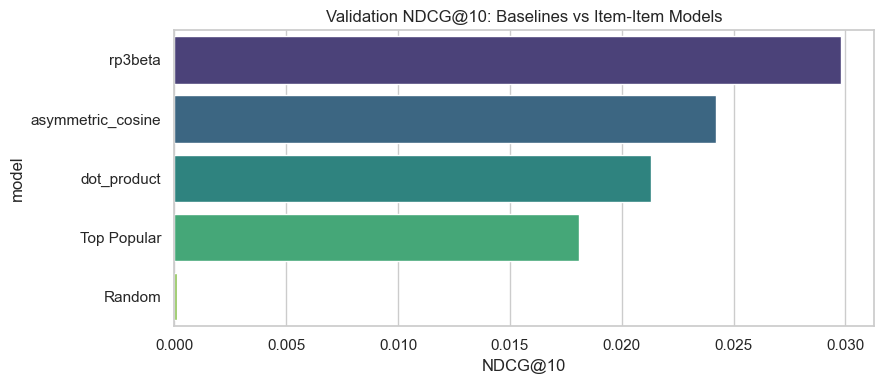

In [17]:
# Quick visual comparison vs baselines on validation
val_compare_df = pd.concat([
    baseline_df[["model", "NDCG@10"]],
    item_item_df[["model", "NDCG@10"]],
], ignore_index=True).sort_values("NDCG@10", ascending=False)

plt.figure(figsize=(9, 4))
sns.barplot(data=val_compare_df, x="NDCG@10", y="model", hue="model", palette="viridis", dodge=False, legend=False)
plt.title("Validation NDCG@10: Baselines vs Item-Item Models")
plt.tight_layout()
plt.show()



## 7) Hyperparameter Optimization (Optuna)

We run **three separate Optuna studies** (one per similarity):
- `dot_product`
- `asymmetric_cosine`
- `rp3beta`

Each study uses TPE with:
- `10` random startup trials
- `30` optimization trials
- `40` total trials per model

Search space includes:
- common: `normalization` (`none`, `bm25`, `tfidf`), `k`, `shrink`, `shrink_type`
- model-specific:
  - `asymmetric_cosine`: `alpha`
  - `rp3beta`: `alpha`, `beta`

Objective: maximize **Validation NDCG@10** on GTS targets (`last/random`).



In [19]:
# Keep tuning practical; set to None for full validation targets.
VAL_TARGETS_OPTUNA = sample_targets(val_targets_all, max_users=5000, seed=123)

MODELS_TO_OPTIMIZE = ["dot_product", "asymmetric_cosine", "rp3beta"]
N_RANDOM_TRIALS = 10
N_OPT_TRIALS = 30
N_TRIALS_PER_MODEL = N_RANDOM_TRIALS + N_OPT_TRIALS


def suggest_model_params(trial, model_name):
    params = {
        "normalization": trial.suggest_categorical("normalization", ["none", "bm25", "tfidf"]),
        "k": trial.suggest_int("k", 50, 500),
        "shrink": trial.suggest_int("shrink", 0, 500),
        "shrink_type": trial.suggest_categorical("shrink_type", ["stabilized", "bayesian", "additive"]),
    }

    if model_name == "asymmetric_cosine":
        params["alpha"] = trial.suggest_float("asym_alpha", 0.1, 0.9, step=0.05)
    elif model_name == "rp3beta":
        params["alpha"] = trial.suggest_float("rp3_alpha", 0.3, 1.5, step=0.05)
        params["beta"] = trial.suggest_float("rp3_beta", 0.0, 1.5, step=0.05)

    return params


def make_objective(model_name):
    def objective(trial):
        params = suggest_model_params(trial, model_name)
        normalization = params.pop("normalization")

        train_matrix = item_user_train_val_by_norm[normalization]
        W = train_item_similarity(model_name, train_matrix, **params)

        metrics = evaluate_sparse_item_model_on_targets(
            W,
            targets_df=VAL_TARGETS_OPTUNA,
            k=10,
            batch_size=1024,
            fallback_items=popular_items_val,
        )

        ndcg = metrics["NDCG@10"]
        trial.set_user_attr("model", model_name)
        trial.set_user_attr("normalization", normalization)
        trial.set_user_attr("val_precision", metrics["Precision@10"])
        trial.set_user_attr("val_recall", metrics["Recall@10"])

        return ndcg

    return objective


studies_by_model = {}

for idx, model_name in enumerate(MODELS_TO_OPTIMIZE):
    print(f"\n=== Optimizing {model_name} ===")
    sampler = optuna.samplers.TPESampler(seed=42 + idx, n_startup_trials=N_RANDOM_TRIALS)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(make_objective(model_name), n_trials=N_TRIALS_PER_MODEL, show_progress_bar=True)

    studies_by_model[model_name] = study
    print("Best trial:", study.best_trial.number)
    print("Best validation NDCG@10:", round(study.best_value, 6))
    print("Best params:", study.best_params)



[I 2026-02-20 12:04:05,890] A new study created in memory with name: no-name-45995b7e-b74a-41b5-adee-b84355850a8b



=== Optimizing dot_product ===


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2026-02-20 12:04:10,181] Trial 0 finished with value: 0.02389204293149209 and parameters: {'normalization': 'bm25', 'k': 319, 'shrink': 78, 'shrink_type': 'additive'}. Best is trial 0 with value: 0.02389204293149209.
[I 2026-02-20 12:04:14,734] Trial 1 finished with value: 0.026433437490879147 and parameters: {'normalization': 'bm25', 'k': 487, 'shrink': 417, 'shrink_type': 'stabilized'}. Best is trial 1 with value: 0.026433437490879147.
[I 2026-02-20 12:04:18,516] Trial 2 finished with value: 0.023716855925296217 and parameters: {'normalization': 'bm25', 'k': 181, 'shrink': 306, 'shrink_type': 'additive'}. Best is trial 1 with value: 0.026433437490879147.
[I 2026-02-20 12:04:20,694] Trial 3 finished with value: 0.01723647480739338 and parameters: {'normalization': 'bm25', 'k': 281, 'shrink': 296, 'shrink_type': 'bayesian'}. Best is trial 1 with value: 0.026433437490879147.
[I 2026-02-20 12:04:23,046] Trial 4 finished with value: 0.01723647480739338 and parameters: {'normalization':

[I 2026-02-20 12:06:33,824] A new study created in memory with name: no-name-12bdfa9f-57ab-43aa-a707-7befcf07cd7a


[I 2026-02-20 12:06:33,822] Trial 39 finished with value: 0.020090485428820228 and parameters: {'normalization': 'tfidf', 'k': 399, 'shrink': 281, 'shrink_type': 'stabilized'}. Best is trial 22 with value: 0.026946595104297092.
Best trial: 22
Best validation NDCG@10: 0.026947
Best params: {'normalization': 'bm25', 'k': 446, 'shrink': 347, 'shrink_type': 'stabilized'}

=== Optimizing asymmetric_cosine ===


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2026-02-20 12:06:37,502] Trial 0 finished with value: 0.022976344932362287 and parameters: {'normalization': 'bm25', 'k': 158, 'shrink': 163, 'shrink_type': 'stabilized', 'asym_alpha': 0.1}. Best is trial 0 with value: 0.022976344932362287.
[I 2026-02-20 12:06:41,555] Trial 1 finished with value: 0.025843784870824515 and parameters: {'normalization': 'tfidf', 'k': 164, 'shrink': 28, 'shrink_type': 'stabilized', 'asym_alpha': 0.35}. Best is trial 1 with value: 0.025843784870824515.
[I 2026-02-20 12:06:48,303] Trial 2 finished with value: 0.01306030380489278 and parameters: {'normalization': 'tfidf', 'k': 488, 'shrink': 193, 'shrink_type': 'stabilized', 'asym_alpha': 0.15000000000000002}. Best is trial 1 with value: 0.025843784870824515.
[I 2026-02-20 12:06:50,776] Trial 3 finished with value: 0.023253846446553456 and parameters: {'normalization': 'none', 'k': 52, 'shrink': 272, 'shrink_type': 'additive', 'asym_alpha': 0.85}. Best is trial 1 with value: 0.025843784870824515.
[I 2026-0

[I 2026-02-20 12:20:14,424] A new study created in memory with name: no-name-8d594558-a2b2-4130-9acd-d1236d0604ef


[I 2026-02-20 12:20:14,422] Trial 39 finished with value: 0.028166080070665966 and parameters: {'normalization': 'tfidf', 'k': 206, 'shrink': 463, 'shrink_type': 'bayesian', 'asym_alpha': 0.5}. Best is trial 25 with value: 0.030312528609598734.
Best trial: 25
Best validation NDCG@10: 0.030313
Best params: {'normalization': 'bm25', 'k': 191, 'shrink': 423, 'shrink_type': 'bayesian', 'asym_alpha': 0.55}

=== Optimizing rp3beta ===


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2026-02-20 12:20:19,505] Trial 0 finished with value: 0.014975629108984319 and parameters: {'normalization': 'none', 'k': 212, 'shrink': 180, 'shrink_type': 'stabilized', 'rp3_alpha': 0.9000000000000001, 'rp3_beta': 1.1}. Best is trial 0 with value: 0.014975629108984319.
[I 2026-02-20 12:20:22,290] Trial 1 finished with value: 0.024186408317179733 and parameters: {'normalization': 'none', 'k': 101, 'shrink': 109, 'shrink_type': 'stabilized', 'rp3_alpha': 1.1, 'rp3_beta': 0.30000000000000004}. Best is trial 1 with value: 0.024186408317179733.
[I 2026-02-20 12:20:25,969] Trial 2 finished with value: 0.024640788769086715 and parameters: {'normalization': 'none', 'k': 444, 'shrink': 129, 'shrink_type': 'bayesian', 'rp3_alpha': 1.0, 'rp3_beta': 0.2}. Best is trial 2 with value: 0.024640788769086715.
[I 2026-02-20 12:20:29,255] Trial 3 finished with value: 0.022873966773461377 and parameters: {'normalization': 'tfidf', 'k': 255, 'shrink': 398, 'shrink_type': 'stabilized', 'rp3_alpha': 0.9

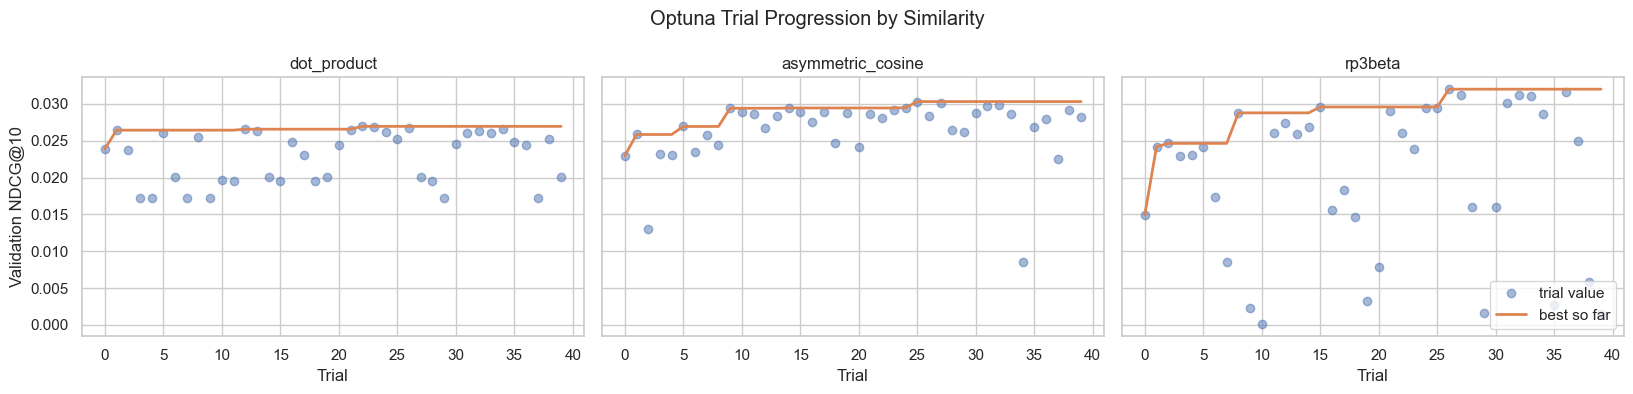

In [20]:
# Optimization progression plots (one panel per similarity)
fig, axes = plt.subplots(1, len(MODELS_TO_OPTIMIZE), figsize=(5.5 * len(MODELS_TO_OPTIMIZE), 4), sharey=True)
if len(MODELS_TO_OPTIMIZE) == 1:
    axes = [axes]

for ax, model_name in zip(axes, MODELS_TO_OPTIMIZE):
    study = studies_by_model[model_name]
    trials_df = study.trials_dataframe(attrs=("number", "value", "state"))
    completed = trials_df[trials_df["state"] == "COMPLETE"].copy().sort_values("number")

    if len(completed) == 0:
        ax.set_title(f"{model_name} (no completed trials)")
        continue

    completed["best_so_far"] = completed["value"].cummax()
    ax.plot(completed["number"], completed["value"], marker="o", linestyle="", alpha=0.5, label="trial value")
    ax.plot(completed["number"], completed["best_so_far"], linewidth=2, label="best so far")
    ax.set_title(model_name)
    ax.set_xlabel("Trial")

axes[0].set_ylabel("Validation NDCG@10")
axes[-1].legend(loc="lower right")
plt.suptitle("Optuna Trial Progression by Similarity")
plt.tight_layout()
plt.show()



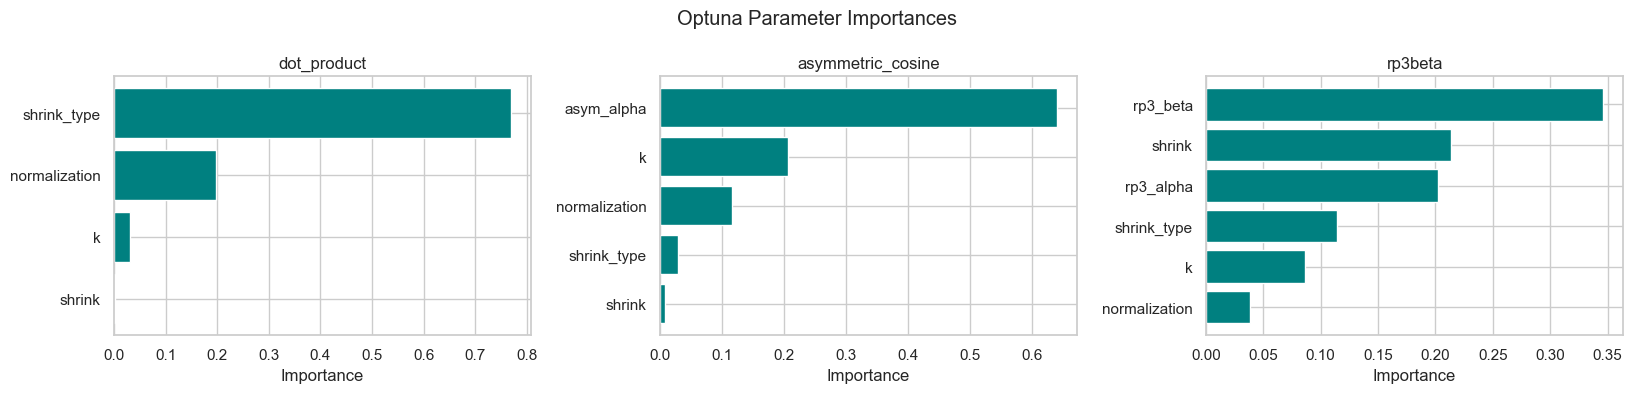

In [21]:
# Parameter importance plots (per similarity)
fig, axes = plt.subplots(1, len(MODELS_TO_OPTIMIZE), figsize=(5.5 * len(MODELS_TO_OPTIMIZE), 4))
if len(MODELS_TO_OPTIMIZE) == 1:
    axes = [axes]

for ax, model_name in zip(axes, MODELS_TO_OPTIMIZE):
    study = studies_by_model[model_name]
    try:
        importances = get_param_importances(study)
        imp_df = pd.DataFrame({"param": list(importances.keys()), "importance": list(importances.values())})
        imp_df = imp_df.sort_values("importance", ascending=True)

        ax.barh(imp_df["param"], imp_df["importance"], color="teal")
        ax.set_title(model_name)
        ax.set_xlabel("Importance")
    except Exception as e:
        ax.axis("off")
        ax.set_title(f"{model_name} (importance unavailable)")
        ax.text(0.0, 0.5, str(e), va="center", fontsize=9)

plt.suptitle("Optuna Parameter Importances")
plt.tight_layout()
plt.show()



In [22]:
# Best run summary for each similarity
best_model_trials = {model_name: studies_by_model[model_name].best_trial for model_name in MODELS_TO_OPTIMIZE}

rows = []
for model_name in MODELS_TO_OPTIMIZE:
    t = best_model_trials[model_name]
    p = t.params
    rows.append(
        {
            "model": model_name,
            "best_trial": t.number,
            "val_ndcg@10": t.value,
            "normalization": p.get("normalization", "none"),
            "k": p.get("k", np.nan),
            "shrink": p.get("shrink", np.nan),
            "shrink_type": p.get("shrink_type", np.nan),
            "alpha": p.get("asym_alpha", p.get("rp3_alpha", np.nan)),
            "beta": p.get("rp3_beta", np.nan),
        }
    )

best_runs_df = pd.DataFrame(rows).sort_values("val_ndcg@10", ascending=False).reset_index(drop=True)
best_runs_df



,model,best_trial,val_ndcg@10,normalization,k,shrink,shrink_type,alpha,beta
0,rp3beta,26,0.031994,tfidf,473,75,bayesian,0.50,1.25
1,asymmetric_cosine,25,0.030313,bm25,191,423,bayesian,0.55,NaN
2,dot_product,22,0.026947,bm25,446,347,stabilized,NaN,NaN


## 8) Final Evaluation on Test Set

We evaluate:
- Baselines (`Top Popular`, `Random`)
- Best tuned configuration for each item-item algorithm found in the **separate** Optuna studies

Protocol:
- Train models on `train_test` (all data up to the global test cutoff)
- Evaluate on one test target per user from `holdout_test`, using the configured GTS target strategy (`last`/`random`)

Main metric: **NDCG@10** (with Recall@10 and Precision@10 for context).



In [23]:
test_targets_eval = sample_targets(test_targets_all, max_users=30000, seed=777)

item_popularity_test, popular_items_test = build_popularity_ranking(URM_train_test)
item_user_train_test_raw = URM_train_test.T.tocsr()
item_user_train_test_by_norm = {
    norm_name: apply_interaction_normalization(item_user_train_test_raw, norm_name)
    for norm_name in NORMALIZATION_OPTIONS
}

final_rows = []

# Baselines on test targets
test_top_pop = evaluate_recommender_on_targets(
    lambda u, seen, k: recommend_top_pop_from_ranking(popular_items_test, seen, k),
    test_targets_eval,
    k=10,
)
test_top_pop["model"] = "Top Popular"
final_rows.append(test_top_pop)

test_random = evaluate_recommender_on_targets(
    lambda u, seen, k: recommend_random(u, seen, k, seed=42),
    test_targets_eval,
    k=10,
)
test_random["model"] = "Random"
final_rows.append(test_random)

# Tuned item-item models on test targets
trained_tuned_models = {}

for model_name in MODELS_TO_OPTIMIZE:
    trial = best_model_trials.get(model_name)
    if trial is None:
        continue

    p = trial.params
    normalization = p.get("normalization", "none")
    train_matrix = item_user_train_test_by_norm[normalization]

    params = {
        "k": p["k"],
        "shrink": p["shrink"],
        "shrink_type": p.get("shrink_type", "stabilized"),
    }
    if model_name == "rp3beta":
        params["alpha"] = p["rp3_alpha"]
        params["beta"] = p["rp3_beta"]
    elif model_name == "asymmetric_cosine":
        params["alpha"] = p["asym_alpha"]

    W_tuned = train_item_similarity(model_name, train_matrix, **params)
    trained_tuned_models[model_name] = W_tuned

    m = evaluate_sparse_item_model_on_targets(
        W_tuned,
        targets_df=test_targets_eval,
        k=10,
        batch_size=1024,
        fallback_items=popular_items_test,
    )
    m["model"] = f"{model_name} (tuned)"
    final_rows.append(m)

final_test_df = pd.DataFrame(final_rows)[["model", "n_users", "Precision@10", "Recall@10", "NDCG@10"]]
final_test_df = final_test_df.sort_values("NDCG@10", ascending=False).reset_index(drop=True)
final_test_df



,model,n_users,Precision@10,Recall@10,NDCG@10
0,rp3beta (tuned),18446,0.006256,0.062561,0.032495
1,asymmetric_cosine (tuned),18446,0.005448,0.054483,0.027928
2,dot_product (tuned),18446,0.004142,0.041418,0.020862
3,Top Popular,18446,0.003161,0.031606,0.016293
4,Random,18446,0.000038,0.000379,0.000157


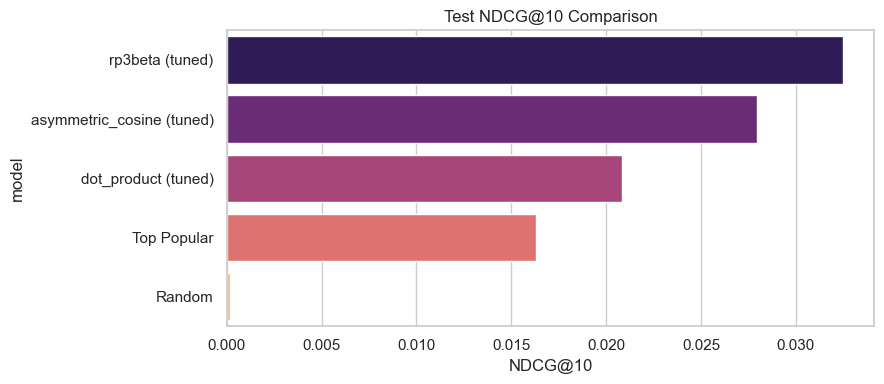

In [24]:
plt.figure(figsize=(9, 4))
sns.barplot(data=final_test_df, x="NDCG@10", y="model", hue="model", palette="magma", dodge=False, legend=False)
plt.title("Test NDCG@10 Comparison")
plt.tight_layout()
plt.show()



## 9) Recommendation Examples

For two representative users, compare:
- Top Popular
- Best tuned item-item model

Recommendations are generated from the user's **pre-target context** under the GTS protocol and displayed with `title` and `genres`.

For transparency, we also show the **user profile used for scoring** (context items before the target timestamp).



In [25]:
# Build metadata lookup by item_idx
item_map_df = pd.DataFrame({
    "movieId": unique_items,
    "item_idx": np.arange(len(unique_items), dtype=np.int32),
})
movie_lookup = item_map_df.merge(movies[["movieId", "title", "genres", "release_year", "release_decade", "decade_label"]], on="movieId", how="left")
movie_lookup = movie_lookup.set_index("item_idx")

# Pick best tuned item-item model by test NDCG if available
item_model_rows = final_test_df[final_test_df["model"].str.contains("tuned", regex=False)]
if len(item_model_rows) > 0:
    best_model_label = item_model_rows.iloc[0]["model"]
    best_model_name = best_model_label.replace(" (tuned)", "")
else:
    # fallback to best default model from validation
    best_model_name = item_item_df.sort_values("NDCG@10", ascending=False).iloc[0]["model"]

if best_model_name in trained_tuned_models:
    W_best = trained_tuned_models[best_model_name]
else:
    W_best = trained_default_models[best_model_name]

print("Best item-item model for examples:", best_model_name)



Best item-item model for examples: rp3beta


In [26]:
def recommend_user_with_similarity(context_items, W, k=10, fallback_items=None):
    if fallback_items is None:
        fallback_items = np.argsort(-np.asarray(W.sum(axis=0)).ravel())

    context_items = np.asarray(context_items, dtype=np.int32)
    x = sp.csr_matrix(
        (np.ones(len(context_items), dtype=np.float32), (np.zeros(len(context_items), dtype=np.int32), context_items)),
        shape=(1, W.shape[0]),
        dtype=np.float32,
    )

    row = x.dot(W).tocsr()
    recs = _topk_from_sparse_row(row.indices, row.data, context_items, k=k, fallback_items=fallback_items)
    return recs


def recs_to_table(rec_items):
    out = pd.DataFrame({"item_idx": rec_items})
    out = out.join(movie_lookup[["movieId", "title", "genres"]], on="item_idx")
    return out[["item_idx", "movieId", "title", "genres"]]


def context_profile_table(user_idx, target_event_idx, context_items, max_rows=30):
    context_items = np.asarray(context_items, dtype=np.int32)
    if len(context_items) == 0:
        return pd.DataFrame(columns=["item_idx", "movieId", "title", "genres", "interaction_time"])

    ctx_set = set(context_items.tolist())
    prof = interactions_global[
        (interactions_global["user_idx"] == int(user_idx))
        & (interactions_global["event_idx"] < int(target_event_idx))
        & (interactions_global["item_idx"].isin(ctx_set))
    ][["item_idx", "timestamp"]].copy()

    prof["interaction_time"] = pd.to_datetime(prof["timestamp"], unit="s")
    prof = (
        prof.drop(columns=["timestamp"])
        .sort_values("interaction_time", ascending=False)
        .drop_duplicates("item_idx", keep="first")
    )
    prof = prof.join(movie_lookup[["movieId", "title", "genres"]], on="item_idx")
    prof = prof[["item_idx", "movieId", "title", "genres", "interaction_time"]]

    if len(prof) > max_rows:
        return prof.head(max_rows).reset_index(drop=True)
    return prof.reset_index(drop=True)


candidate_targets = test_targets_eval[test_targets_eval["n_context_items"] >= 20].copy()
if len(candidate_targets) < 2:
    candidate_targets = test_targets_eval.copy()

if len(candidate_targets) == 0:
    print("No test targets available for examples.")
else:
    ex_rows = candidate_targets.iloc[[0, len(candidate_targets) // 2]].reset_index(drop=True)

    for row in ex_rows.itertuples(index=False):
        u = int(row.user_idx)
        context_items = row.context_items
        target_item = int(row.target_item_idx)
        target_ts = int(row.target_timestamp)
        target_event_idx = int(row.target_event_idx)

        rec_pop = recommend_top_pop_from_ranking(popular_items_test, context_items, k=10)
        rec_best = recommend_user_with_similarity(context_items, W_best, k=10, fallback_items=popular_items_test)

        target_meta = movie_lookup.loc[target_item] if target_item in movie_lookup.index else None

        print(f"\n=== User idx: {u} (original userId: {idx_to_user[u]}) ===")
        print("Target timestamp:", pd.to_datetime(target_ts, unit="s"))
        print("Context length used for scoring:", len(context_items))
        if target_meta is not None:
            print("Held-out target:", target_meta["title"], "|", target_meta["genres"])

        profile_df = context_profile_table(u, target_event_idx, context_items, max_rows=30)
        print("\nUser profile used for recommendation (most recent context items):")
        display(profile_df)
        if len(context_items) > len(profile_df):
            print(f"(Showing 30/{len(context_items)} context items)")

        print("\nTop Popular recommendations:")
        display(recs_to_table(rec_pop))

        print(f"\n{best_model_name} recommendations:")
        display(recs_to_table(rec_best))




=== User idx: 76344 (original userId: 76741) ===
Target timestamp: 2021-01-30 07:45:53
Context length used for scoring: 61
Held-out target: Guardians of the Galaxy (2014) | Action|Adventure|Sci-Fi

User profile used for recommendation (most recent context items):


,item_idx,movieId,title,genres,interaction_time
0,2055,152081,Zootopia (2016),Action|Adventure|Animation|Children|Comedy,2021-01-30 07:45:30
1,1785,88129,Drive (2011),Crime|Drama|Film-Noir|Thriller,2021-01-30 07:44:49
2,6329,109864,Veronica Mars (2014),Comedy|Crime|Drama,2021-01-30 07:43:44
3,1140,109487,Interstellar (2014),Sci-Fi|IMAX,2021-01-30 07:42:18
4,7037,222011,Greenland (2020),Action|Sci-Fi|Thriller,2021-01-30 07:41:53
5,8430,112940,A Most Wanted Man (2014),Thriller,2021-01-30 07:41:40
6,2979,179401,Jumanji: Welcome to the Jungle (2017),Action|Adventure|Children,2020-12-09 13:01:25
7,5289,207233,Jumanji: The Next Level (2019),Action|Adventure|Comedy|Fantasy,2020-12-09 13:01:22
8,159,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,2020-12-08 08:47:38
9,1626,31658,Howl's Moving Castle (Hauru no ugoku shiro) (2...,Adventure|Animation|Fantasy|Romance,2020-12-04 10:41:59


(Showing 30/61 context items)

Top Popular recommendations:


,item_idx,movieId,title,genres
0,161,318,"Shawshank Redemption, The (1994)",Crime|Drama
1,21,356,Forrest Gump (1994),Comedy|Drama|Romance|War
2,25,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
3,209,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
4,22,527,Schindler's List (1993),Drama|War
5,356,2959,Fight Club (1999),Action|Crime|Drama|Thriller
6,8,110,Braveheart (1995),Action|Drama|War
7,415,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
8,211,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
9,373,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller



rp3beta recommendations:


,item_idx,movieId,title,genres
0,780,59315,Iron Man (2008),Action|Adventure|Sci-Fi
1,913,112852,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi
2,356,2959,Fight Club (1999),Action|Crime|Drama|Thriller
3,292,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
4,831,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX
5,1247,8961,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy
6,812,68157,Inglourious Basterds (2009),Action|Drama|War
7,1149,116797,The Imitation Game (2014),Drama|Thriller|War
8,920,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi
9,609,6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller



=== User idx: 92791 (original userId: 93274) ===
Target timestamp: 2022-02-26 23:01:03
Context length used for scoring: 501
Held-out target: Trainspotting (1996) | Comedy|Crime|Drama

User profile used for recommendation (most recent context items):


,item_idx,movieId,title,genres,interaction_time
0,1162,148626,"Big Short, The (2015)",Drama,2022-02-26 22:57:17
1,2613,67408,Monsters vs. Aliens (2009),Animation|Sci-Fi|IMAX,2022-02-26 22:56:55
2,855,83613,Cowboys & Aliens (2011),Action|Sci-Fi|Thriller|Western|IMAX,2022-02-26 22:56:46
3,450,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,2022-02-26 22:56:27
4,844,78266,Splice (2009),Horror|Sci-Fi|Thriller,2022-02-26 22:55:54
5,7533,84187,Evangelion: 2.0 You Can (Not) Advance (Evanger...,Action|Animation|Drama|Sci-Fi,2022-02-26 22:49:36
6,7532,70533,Evangelion: 1.0 You Are (Not) Alone (Evangerio...,Action|Animation|Sci-Fi,2022-02-26 22:49:24
7,3388,3552,Caddyshack (1980),Comedy,2022-02-26 22:48:47
8,2064,67734,Adventureland (2009),Comedy|Drama,2022-02-26 22:48:37
9,459,1387,Jaws (1975),Action|Horror,2022-02-26 22:48:15


(Showing 30/501 context items)

Top Popular recommendations:


,item_idx,movieId,title,genres
0,22,527,Schindler's List (1993),Drama|War
1,60,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
2,218,858,"Godfather, The (1972)",Crime|Drama
3,197,150,Apollo 13 (1995),Adventure|Drama|IMAX
4,4,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
5,185,592,Batman (1989),Action|Crime|Thriller
6,184,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
7,168,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
8,170,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller
9,212,590,Dances with Wolves (1990),Adventure|Drama|Western



rp3beta recommendations:


,item_idx,movieId,title,genres
0,609,6874,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
1,831,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX
2,1370,134130,The Martian (2015),Adventure|Drama|Sci-Fi
3,618,7438,Kill Bill: Vol. 2 (2004),Action|Drama|Thriller
4,600,6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy
5,285,5349,Spider-Man (2002),Action|Adventure|Sci-Fi|Thriller
6,715,49272,Casino Royale (2006),Action|Adventure|Thriller
7,654,32587,Sin City (2005),Action|Crime|Film-Noir|Mystery|Thriller
8,358,4011,Snatch (2000),Comedy|Crime|Thriller
9,1149,116797,The Imitation Game (2014),Drama|Thriller|War


## 10) Item-Item Visualization (UMAP)

We project item representations into 2D:
1. Take the best tuned item-item similarity matrix.
2. Select a subset of popular items for readability.
3. Compress with TruncatedSVD, then project with UMAP.
4. Color points by **release decade** (parsed from movie title year).
5. Use spacing-aware selective labels to reduce overlap.



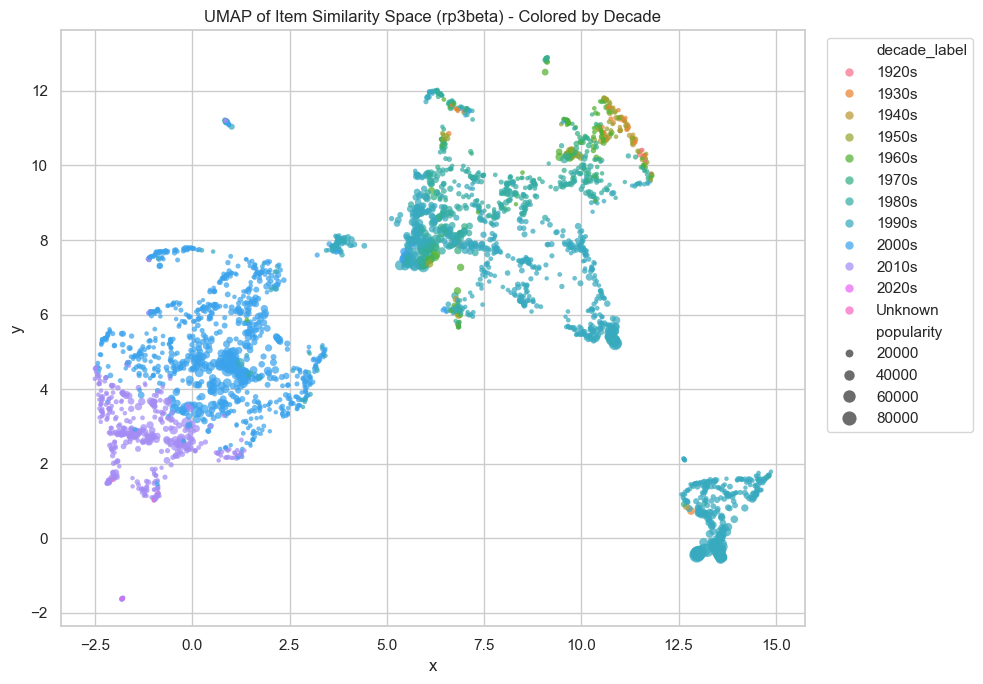

In [27]:
N_VIS_ITEMS = min(3000, n_items)
popular_vis_items = np.argsort(-item_popularity_test)[:N_VIS_ITEMS]

W_vis = W_best[popular_vis_items][:, popular_vis_items].tocsr()
W_vis = ((W_vis + W_vis.T) * 0.5).tocsr()

n_components_svd = min(64, max(2, W_vis.shape[1] - 1))
svd = TruncatedSVD(n_components=n_components_svd, random_state=42)
item_repr = svd.fit_transform(W_vis)

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=42,
    n_jobs=1,
)
coords = umap_model.fit_transform(item_repr)

vis_df = pd.DataFrame({
    "item_idx": popular_vis_items,
    "x": coords[:, 0],
    "y": coords[:, 1],
    "popularity": item_popularity_test[popular_vis_items],
})
vis_df = vis_df.join(
    movie_lookup[["title", "genres", "release_year", "release_decade", "decade_label"]],
    on="item_idx",
)
vis_df["decade_label"] = vis_df["decade_label"].fillna("Unknown")

# Order decades chronologically in legend
known_decades = sorted([int(v) for v in vis_df["release_decade"].dropna().unique()])
ordered_labels = [f"{d}s" for d in known_decades]
if "Unknown" in vis_df["decade_label"].values:
    ordered_labels.append("Unknown")
vis_df["decade_label"] = pd.Categorical(vis_df["decade_label"], categories=ordered_labels, ordered=True)

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=vis_df,
    x="x",
    y="y",
    hue="decade_label",
    size="popularity",
    sizes=(10, 120),
    alpha=0.72,
    linewidth=0,
)
plt.title(f"UMAP of Item Similarity Space ({best_model_name}) - Colored by Decade")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()




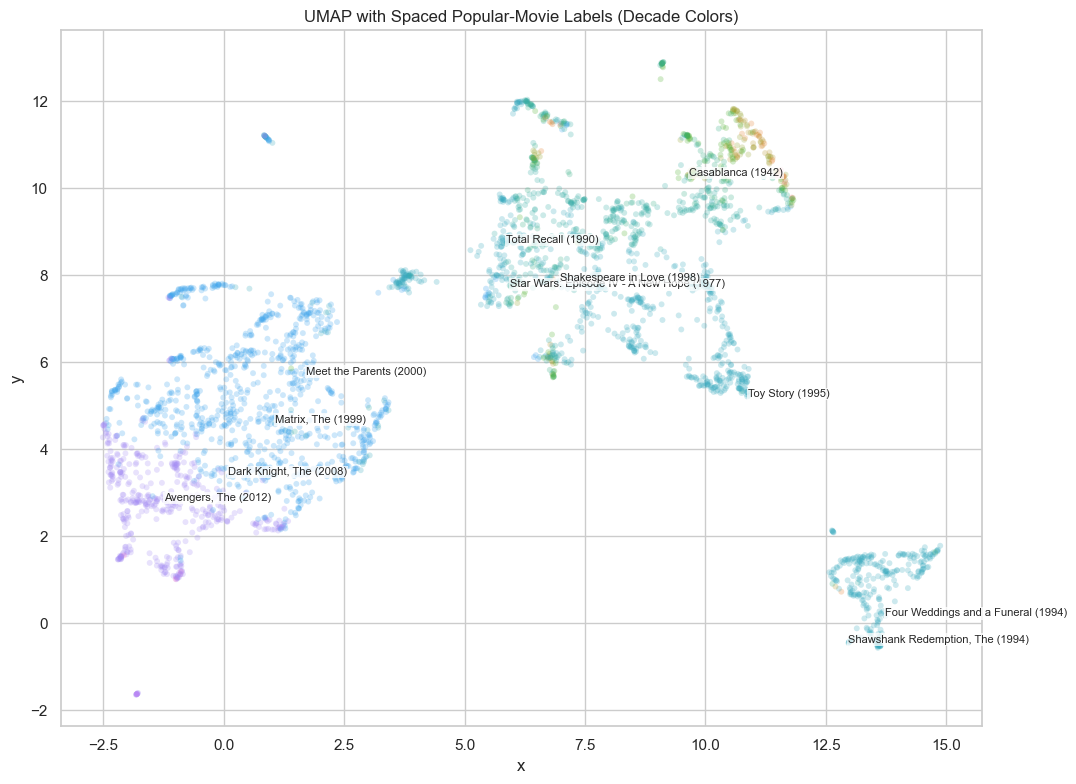

In [28]:
# Spacing-aware selective annotation to reduce label overlap

def select_spread_labels(df, candidate_top=250, max_labels=30, min_dist_ratio=0.06):
    cand = df.sort_values("popularity", ascending=False).head(candidate_top).copy()

    x_span = max(df["x"].max() - df["x"].min(), 1e-9)
    y_span = max(df["y"].max() - df["y"].min(), 1e-9)
    min_dist = min_dist_ratio * np.sqrt(x_span * y_span)
    min_dist2 = min_dist * min_dist

    selected = []
    for row in cand.itertuples(index=False):
        keep = True
        for sx, sy, _ in selected:
            if (row.x - sx) ** 2 + (row.y - sy) ** 2 < min_dist2:
                keep = False
                break
        if keep:
            selected.append((row.x, row.y, row))
        if len(selected) >= max_labels:
            break

    return [r for _, _, r in selected]


selected_rows = select_spread_labels(
    vis_df,
    candidate_top=250,
    max_labels=30,
    min_dist_ratio=0.06,
)

plt.figure(figsize=(11, 8))
sns.scatterplot(
    data=vis_df,
    x="x",
    y="y",
    hue="decade_label",
    alpha=0.25,
    s=18,
    linewidth=0,
    legend=False,
)

for i, row in enumerate(selected_rows):
    dx = 0.015 * (-1 if i % 2 == 0 else 1)
    dy = 0.012 * (1 if (i // 2) % 2 == 0 else -1)
    plt.text(
        row.x + dx,
        row.y + dy,
        str(row.title),
        fontsize=8,
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", pad=0.8),
    )

plt.title("UMAP with Spaced Popular-Movie Labels (Decade Colors)")
plt.tight_layout()
plt.show()



## 11) Summary & Insights

### What worked
- Item-item collaborative filtering improved over non-personalized baselines.
- RP3Beta and Asymmetric Cosine generally benefited from tuning neighborhood size, shrinkage, and regularization.
- Using a global-timestamp protocol (GTS) with `last`/`random` targets gives a stricter and more realistic temporal evaluation than user-wise splits.
- SimilariPy made it straightforward to compare multiple item-item algorithms under the same sparse pipeline.

### What was challenging
- Full MovieLens 32M tuning remains computationally expensive.
- Metrics are sensitive to the exact temporal protocol and target choice.

### Practical next steps
1. Add re-ranking with novelty/diversity constraints.
2. Build a hybrid model by combining collaborative scores with content features (genres, embeddings).
3. Compare against matrix factorization and neural CF architectures.



### Reproducibility Notes

- This notebook uses a global-timestamp split (GTS) with one target per user (`last` or `random`) and binary implicit interactions.
- Some evaluation cells use user subsampling for practical runtime.
- To maximize rigor, increase sampled users to all validation/test users and increase Optuna trials.
